# Building a Sample for Citizen Science with Galaxy Zoo

The SDSS records colors, redshifts, magnitudes, and more for millions of objects in the sky.  You might wonder what a sample selected in a particular way (e.g., by color) "looks like".  For instance, are blue galaxies characterized by a particular shape?  

In this activity, we will walk through the basic steps required to select a sample of galaxies from the SDSS database, save their images to your SciDrive, and upload them into your own unique citizen science project on [Zooniverse](http://zooniverse.org).  We will then build a basic project to enable your friends and family to help contribute to answering a science question of your choosing.



## I. Importing SciServer and other important libraries
The SciServer team has written a number of libraries, generally prefixed with "SciServer", that assist in various functions. As with all Python libraries, they must be actively imported before being used.
The next code block imports those, together with some standard Python libraries helpful for scientific analysis. The code block below applies some settings you may find helpful.

In [1]:
# Steps to mount Drive to Google Colab
# 1. Run this script
# 2. Click the link in the output of the script.
# 3. Sign in with the appropriate Google account.
# 4. Copy the code from the new page and go back to this page.
# 5. Enter the code in the box and press ENTER
# 6. Wait for the cell to output "Mounted at /content/drive"

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# If you have NOT changed the name of the package file 
# and it is in your main Google Drive directory, leave 
# this path alone. Otherwise, update this path accordingly.
drivePath = 'simpleZooniverse-main'

# Go to the appropriate folder for execution.
!python3 --version
!ls /content/drive/MyDrive/
!cd /content/drive/MyDrive/$drivePath; pwd; pip3 install -r requirements.txt

Python 3.7.10
'Colab Notebooks'			       'My life'
'Copy of Commencement Program Nov2020.pdf'     'My projects'
'iCloud Photos from Susanna Wallenberger.zip'   simpleZooniverse-main
 Learning				        UNCA
/content/drive/MyDrive/simpleZooniverse-main
     |████████████████████████████████| 6.5MB 5.4MB/s 
     |████████████████████████████████| 133kB 37.2MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 51kB 4.3MB/s 
     |████████████████████████████████| 3.2MB 11.6MB/s 
  Created wheel for redo: filename=redo-2.0.4-cp37-none-any.whl size=11931 sha256=0b25c611636c164ad6d8167cca7b27ed0cfafced9302e1c2d44aaf114f78f638
  Stored in directory: /root/.cache/pip/wheels/7e/ca/39/576f2d470fab4725bb098ca3a1889ee540875e2bd072dc7ec0
Successfully built redo
  Created wheel for astroquery: filename=astroquery-0.4.1-cp37-none-any.whl size=3831874 sha256=bf1b9a43bc4055c30327f9aa28

In [3]:
# Import other libraries for use in this notebook.
import os  
import sys
import time
import numpy as np                  # standard Python lib for math ops
from imageio import imsave       # save images as files
import pandas                       # data manipulation package
import matplotlib.pyplot as plt     # another graphing package
import glob
from astropy.table import Table
print('Supporting libraries imported')

# Apply some special settings to the imported libraries
# ensure columns get written completely in notebook
pandas.set_option('display.max_colwidth', -1)
# do *not* show python warnings 
import warnings
warnings.filterwarnings('ignore')
print('Settings applied')

Supporting libraries imported
Settings applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  from ipykernel import kernelapp as app


In [4]:
# Import Python libraries to work with SciServer
if not '/content/drive/MyDrive/{}/'.format(drivePath) in sys.path:
    sys.path.insert(1, '/content/drive/MyDrive/{}/'.format(drivePath))
if not '/content/drive/MyDrive/{}/SciServer'.format(drivePath) in sys.path:
    sys.path.insert(1, '/content/drive/MyDrive/{}/SciServer'.format(drivePath))
if not '/content/drive/MyDrive/{}/zooniversePackage'.format(drivePath) in sys.path:   
    sys.path.insert(1, '/content/drive/MyDrive/{}/zooniversePackage'.format(drivePath))
print(sys.path)
import CasJobs
import SkyServer
import SciDrive # query with CasJobs
print('SciServer libraries imported')

['', '/content/drive/MyDrive/simpleZooniverse-main/zooniversePackage', '/content/drive/MyDrive/simpleZooniverse-main/SciServer', '/content/drive/MyDrive/simpleZooniverse-main/', '/content', '/env/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.7/dist-packages/IPython/extensions', '/root/.ipython']
SciServer libraries imported


## II. Querying an astronomy database (SDSS DR16)
The next code block searches the SDSS Data Release 16 database via the CasJobs REST API. The query completes quickly, so it uses CasJobs quick mode.
CasJobs also has an asynchronous mode, which will submit job to a queue and will store the results in a table in your MyDB. If your results are very large, it will store the results in MyScratchDB instead.
Run the code block below to query DR16. Try changing some of the query parameters in step to see the effect on the results returned.
Documentation on the SciServer Python libraries can be found at our documentation site at:
http://www.sciserver.org/docs
make example with batch query mode.

An extensive tutorial on how to query the SDSS database can be found here:
http://skyserver.sdss.org/dr16/en/help/howto/search/searchhowtohome.aspx

In [5]:
# Find objects in the Sloan Digital Sky Survey's Data Release 16.
#
# Query the Sloan Digital Sky Serveys' Data Release 16.
# For the database schema and documentation see http://skyserver.sdss.org/dr16
#
# This query finds "a 4x4 grid of nice-looking galaxies": 
#   galaxies in the SDSS database that have a spectrum 
#   and have a size (petror90_r) larger than 10 arcsec.
# 
# First, store the query in an object called "query"
query="""
SELECT TOP 16 p.objId,p.ra,p.dec,p.petror90_r, p.g, p.r
  FROM galaxy AS p
   JOIN SpecObj AS s ON s.bestobjid = p.objid
WHERE p.u BETWEEN 0 AND 19.6
  AND p.g BETWEEN 0 AND 17  AND p.petror90_r > 10
"""
gals = CasJobs.executeQuery(query, "dr16")
gals = gals.set_index('objId')
gals

,ra,dec,petror90_r,g,r
objId,,,,,
1237667781775327268,219.594953,18.111218,12.58201,15.60288,14.90701
1237665532251013352,219.592920,23.428761,14.47842,15.66112,14.86994
1237665351318503492,219.591756,27.336304,17.26094,15.94505,15.18246
1237662264855625834,219.588623,9.227637,14.91277,15.31813,14.61456
1237661850943947119,219.585008,39.393224,14.90473,16.72122,16.38783
1237662264855625968,219.580353,9.291655,10.88518,16.84558,15.97781
1237654879665324133,219.578818,3.639681,10.83427,15.93781,15.30992
1237667781238456442,219.577525,17.609425,18.30117,15.18190,14.29627
1237667735059956026,219.614557,18.717180,11.17537,16.82319,16.02281


#### EXPERIMENT:  What happens if you change the query?

Try changing the query in the following ways: 
- Return 24 matching objects insetad of 16.
- Select only nearby galaxies (redshift < 0.05).
- Select only galaxies likely to be spirals (with u-r color >= 2.22)
- Search for galaxies in SDSS Data Release 14 instead of DR16.

What changes do you notice in the table of returned results?

Try it in the code block below:

In [6]:
# Find objects in the Sloan Digital Sky Survey's Data Release 14.
# First, store the query in an object called "query"
query="""
SELECT TOP 24 p.objId,p.ra,p.dec,p.petror90_r, p.g, p.r
  FROM galaxy AS p
   JOIN SpecObj AS s ON s.bestobjid = p.objid
WHERE p.u BETWEEN 0 AND 19.6
  AND p.g BETWEEN 0 AND 17
  AND p.petror90_r > 10
  AND s.z <0.05
  AND p.u-p.r>=2.2
"""
gals = CasJobs.executeQuery(query, "dr14")
gals = gals.set_index('objId')
gals

,ra,dec,petror90_r,g,r
objId,,,,,
1237651066277789860,176.180966,64.583086,10.75060,15.92303,15.04134
1237651504882188321,207.815902,0.391188,13.42526,16.80897,16.06380
1237648721752621257,145.800180,0.414172,19.92908,15.42035,14.50936
1237645941824356443,40.285690,-0.714957,14.72862,15.75164,15.03100
1237648722288574515,143.663829,0.688079,13.57360,15.58319,14.66213
1237649921118634099,27.803645,14.925777,10.89873,16.31558,15.41293
1237651190817751248,124.092428,45.791000,11.59291,16.09130,15.17758
1237651249899438304,231.977623,54.269795,17.07298,15.45065,14.52571
1237651066279821325,186.834813,64.801507,38.55878,13.20555,12.44427


# IV. Store results in your container for later use
The next code block saves the data table "gals" as an HD5 file and as a CSV file.

To see these files, go back to your iPython notebook dashboard (the page from which you opened this notebook). Make sure you are in the persistent folder. You should see your files there. Click on the file names to preview.


In [ ]:
# store result as HDF5 file 
h5store = pandas.HDFStore('GalaxyThumbSample.h5')
h5store['galaxies']=gals
h5store.close()

# store result as CSV file
gals.to_csv('GalaxyThumbSample.csv')

print ("Done.")

Done.



# V. Retrieve thumbnail cutouts of galaxies and show them on screen
SkyServer has a service that will produce a color image cutout of certain dimensions around a specified position, displayed as a JPG thumbnail.

The code below iterates through each galaxy in your results and calls the image cutout generator for each galaxy. The scale of the image depends on the Petrosian radius of the galaxy.

Getting image 1 of 24...
Getting image 2 of 24...
Getting image 3 of 24...
Getting image 4 of 24...
Getting image 5 of 24...
Getting image 6 of 24...
Getting image 7 of 24...
Getting image 8 of 24...
Getting image 9 of 24...
Getting image 10 of 24...
Getting image 11 of 24...
Getting image 12 of 24...
Getting image 13 of 24...
Getting image 14 of 24...
Getting image 15 of 24...
Getting image 16 of 24...
Getting image 17 of 24...
Getting image 18 of 24...
Getting image 19 of 24...
Getting image 20 of 24...
Getting image 21 of 24...
Getting image 22 of 24...
Getting image 23 of 24...
Getting image 24 of 24...
Plotting images...


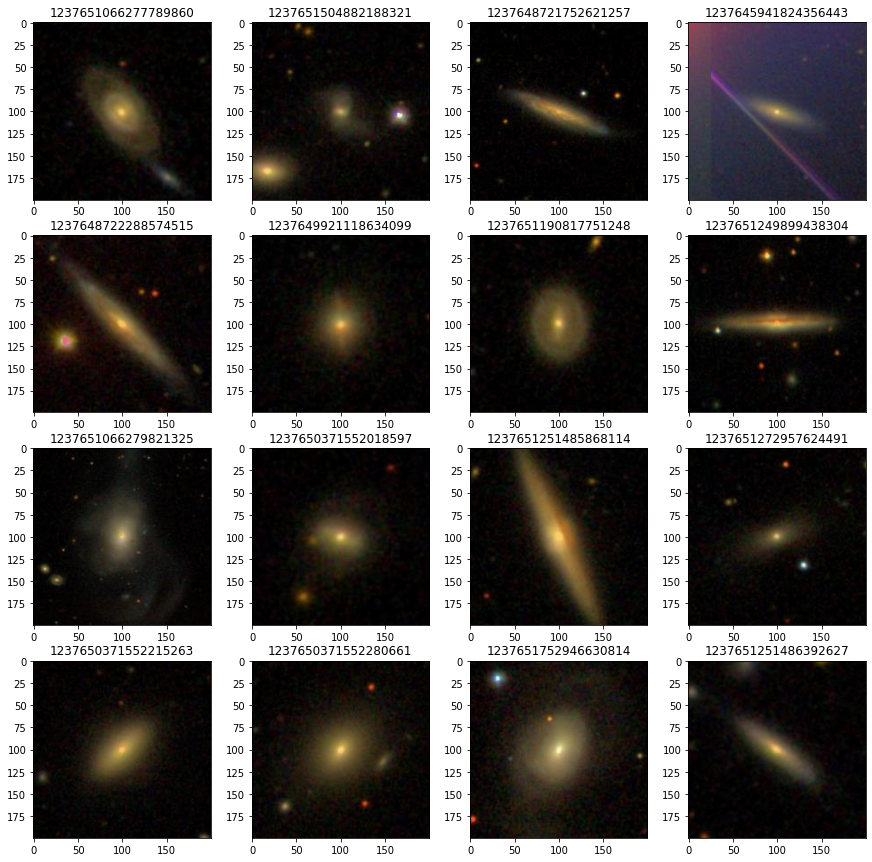

In [7]:
# set thumbnail parameters
width=200           # image width
height=200          # height
pixelsize=0.396     # image scale
plt.figure(figsize=(15, 15))   # display in a 4x4 grid
subPlotNum = 1

i = 0
nGalaxies = len(gals)
for index,gal in gals.iterrows():           # iterate through rows in the DataFrame
    i = i + 1
    print('Getting image '+str(i)+' of '+str(nGalaxies)+'...')
    if (i == nGalaxies):
        print('Plotting images...')
    scale=2*gal['petror90_r']/pixelsize/width
    img = SkyServer.getJpegImgCutout(ra=gal['ra'], dec=gal['dec'], width=width, height=height, scale=scale,dataRelease='DR16')
    
    # Preview the first 16 with this command
    if i < 17:
        plt.subplot(4,4,subPlotNum)
    
    ## Preview the full sample of the galaxies by un-commenting the following command:
    #plt.subplot(int(len(gals)/4)+1,4,subPlotNum)
    
    subPlotNum += 1
    plt.imshow(img)                               # show images in grid
    plt.title(index)                            # show the object identifier (objId) above the image.

plt.show()

# VI. Write thumbnails to Google Drive

The three code blocks below work together to write the thumbnails you generated in step 6 into your Google Drive.

In [8]:
# Step 7b: Specify the directory in your Google Drive to hold the thumbnail images
mydir = '/content/drive/MyDrive/{}/subjects'.format(drivePath)

# Makes a new local directory if there is no local directory named 'subjects'
if not os.path.isdir(mydir):
    os.mkdir(mydir)
else:
    for f in glob.glob(mydir+'/*'):
        os.remove(f)  

# set thumbnail parameters
width=200           # image width
height=200          # height
pixelsize=0.396     # image scale
        
# make a name for your "manifest" -- the table that matches your images to known information about the galaxies
fout = open(mydir+'/galaxy_manifest.csv', 'w')
fout.write("index, image, ra, dec \n")

# Write thumbnails to Google Drive. You will see a confirmation message when each is written
i = 0
puburls=[]
localArray = []
for index,gal in gals.iterrows():   
    i = i + 1
    print('Writing image file '+str(i)+' of '+str(len(gals))+'...')
    scale=2*gal['petror90_r']/pixelsize/width
    img = SkyServer.getJpegImgCutout(ra=gal['ra'], dec=gal['dec'], width=width, height=height, scale=scale,dataRelease='DR14')
    localname = str(index)+'.jpg'
    localpath = mydir+'/'+str(index)+'.jpg'
    # Here the file is saved to Google Drive 
    imsave(localpath,img)
    localArray.append(localpath)
    fout.write('{}, {}.jpg, {}, {}\n'.format(index,index,gal['ra'],gal['dec']))
fout.close()

print('Done!')

Writing image file 1 of 24...
Writing image file 2 of 24...
Writing image file 3 of 24...
Writing image file 4 of 24...
Writing image file 5 of 24...
Writing image file 6 of 24...
Writing image file 7 of 24...
Writing image file 8 of 24...
Writing image file 9 of 24...
Writing image file 10 of 24...
Writing image file 11 of 24...
Writing image file 12 of 24...
Writing image file 13 of 24...
Writing image file 14 of 24...
Writing image file 15 of 24...
Writing image file 16 of 24...
Writing image file 17 of 24...
Writing image file 18 of 24...
Writing image file 19 of 24...
Writing image file 20 of 24...
Writing image file 21 of 24...
Writing image file 22 of 24...
Writing image file 23 of 24...
Writing image file 24 of 24...
Done!


# Uploading your data to Zooniverse

Your thumbnails will now be collected in your Google Drive. This should have been saved in the same Google Drive directory as your images.

If you haven't already, you'll now need to make an account on [Zooniverse](https://www.zooniverse.org/).

*blurb for zooniverse scripts

In [10]:
import getpass

print('Enter your Zooniverse username and password')

username = input('Username: ')
password = getpass.getpass('Password: ')

print('Welcome ' + username)

import zooniverseScripts as zooni

projectName = 'Zooniverse Tutorial Project today for  '+ username
imgLoc = [mydir]

zooni.run(username, password, projectName, imgLoc, tutorial=True)

Enter your Zooniverse username and password
Username: oostoos3
Password: ··········
Welcome oostoos3
--- --- --- ---
Establishing connection to Zooniverse and creating project
Attempting connection.
<Response [200]>
Project successfully created.
/content/drive/MyDrive/simpleZooniverse-main/subjects/1237651066277789860.jpg
/content/drive/MyDrive/simpleZooniverse-main/subjects/1237651504882188321.jpg
/content/drive/MyDrive/simpleZooniverse-main/subjects/1237648721752621257.jpg
/content/drive/MyDrive/simpleZooniverse-main/subjects/1237645941824356443.jpg
/content/drive/MyDrive/simpleZooniverse-main/subjects/1237648722288574515.jpg
/content/drive/MyDrive/simpleZooniverse-main/subjects/1237649921118634099.jpg
/content/drive/MyDrive/simpleZooniverse-main/subjects/1237651190817751248.jpg
/content/drive/MyDrive/simpleZooniverse-main/subjects/1237651249899438304.jpg
/content/drive/MyDrive/simpleZooniverse-main/subjects/1237651066279821325.jpg
/content/drive/MyDrive/simpleZooniverse-main/subject